This notebook represents the submission of Team 1 to the HQAN/IBM Hackathon. The objective of the hackathon was to perform a classification of the Iris dataset using a quantum classifier with accuracy at or above the state of the art. While we regrettably don't achieve this high aim, we do demonstrate a quantum classifier that leverages only one qubit and a somewhat novel classification scheme.

In [2]:
import numpy as np
from numpy import pi
from sklearn.decomposition import KernelPCA
from sklearn import datasets
import seaborn as sns
import pandas as pd
from scipy.stats import norm, boxcox
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter, ParameterVector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM
from typing import Union, Optional, Callable, Tuple, cast

import scipy.sparse
from qiskit.algorithms.optimizers import Optimizer
from scipy.sparse import spmatrix
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from qiskit_machine_learning.algorithms.objective_functions import (
    BinaryObjectiveFunction,
    OneHotObjectiveFunction,
    MultiClassObjectiveFunction,
    ObjectiveFunction,
)
from qiskit_machine_learning.algorithms.trainable_model import TrainableModel
from qiskit_machine_learning.neural_networks import NeuralNetwork
from qiskit_machine_learning.utils.loss_functions import Loss
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from sklearn.model_selection import StratifiedKFold
from qiskit_machine_learning.exceptions import QiskitMachineLearningError, QiskitError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-03 23:29:40,271: Credentials are already in use. The existing account in the session will be replaced.


In [25]:

def callback_graph(weights, obj_func_eval):
    """
        Prints the forward pass objective function valuation
        Arguments:
            weights: trainable neural network weights
            obj_func_eval: forward pass objective function valuation 
        Returns:
            forward pass objective function valuation
    """
    print(obj_func_eval)
    
def parity(x):
    """
        Parity of a bitstring
        Arguments:
            x: integer
        Returns:
            parity of x
    """
    return "{:b}".format(x).count("1") % 2


def pre_process(df_train,df_test,n_components,feature_cols,new_cols,kernel='poly',min_max_range=(-1.9*np.pi/2,1.9*np.pi/2)):
    """
        Preprocesses by performing a normalization, followed by a kernel principal component analysis,
        followed by a min-max scaling.
        Arguments:
            df_train: training set, assumed to be a dataframe
            df_test: test set, assumed to be a dataframe. Must have the same column names as df_train.
            n_components: number of components output by the kernel PCA
            feature_cols: feature columns to be transformed
            new_cols: names of columns output by the kernel PCA
            kernel: choice of kernel for the kernel PCA
            min_max_range: range Sklearn's MinMaxScaler constrains output to
        Returns:
            df_train_t: the transformed training data
            df_test_t: the transformed test data
    """
    pca = KernelPCA(n_components = n_components,random_state=12345,kernel=kernel)
    stsc = StandardScaler()
    mmsc = MinMaxScaler(feature_range=min_max_range)
    target_col = ['target'] 
    df_train_t= pd.DataFrame(np.hstack([mmsc.fit_transform(pca.fit_transform(stsc.fit_transform(df_train[feature_cols]))),df_train.target.values[:,None]]),columns =new_cols+target_col)
    # df_train_t= pd.DataFrame(np.hstack([mmsc.fit_transform(pca.fit_transform(df_train[feature_cols])),df_train.target.values[:,None]]),columns =new_cols+target_col)
    df_test_t =  pd.DataFrame(np.hstack([mmsc.transform(pca.transform(stsc.transform(df_test[feature_cols]))),df_test.target.values[:,None]]),columns =new_cols + target_col)
    # df_test_t =  pd.DataFrame(np.hstack([mmsc.transform(pca.transform(df_test[feature_cols])),df_test.target.values[:,None]]),columns =new_cols + target_col)
    
    return df_train_t, df_test_t



def turn_target_to_prob(y,prob_arr):
    """
        Convert the integer target labels into distributions
        Arguments:
            y: array of integer target labels
            prob_arr: an (n,2) ndarray for n classes; row i correspond to a distribution corresponding to label i
        Returns:
            an (len(y),2) ndarray of distributions labeling each class
    """
    return prob_arr[y]
  
def extract_classification(y_test,y_predict,prob_arr):
    """
        Compare the target and prediction distribution (squared loss) and compute an accuracy, as well 
        as return the prediction classification
        Arguments:
            y_test: integer labels of classification of test set
            y_predict: (len(y_test),2) ndarray of distributions, one per row
        Returns:
            acc_score: the accuracy score of the prediction versus actual
            y_p: the integer classification labels of the prediction   
    """
    #come back and fix this 
    y_p = np.zeros(len(y_test))
    for row,val in enumerate(y_predict):
        tmp = val * np.ones((3,2))
        y_p[row] = np.argmin(np.sum((tmp-prob_arr)**2,axis=1))
        acc_score= accuracy_score(y_test,y_p)
    return acc_score,y_p

Because of the unconventional classification scheme we use, and the manner in which NeuralNetworkClassifier implemented its predict function, we modified the class. Our modification occurs only in the predict function, wherein we simply output the probabilities rather than taking an argmin over probabilities.

In [26]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2021, 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
"""An implementation of quantum neural network classifier."""




class NeuralNetworkClassifier_Greg_Version(TrainableModel, ClassifierMixin):
    """Quantum neural network classifier. Implements Scikit-Learn compatible methods for
    classification and extends ``ClassifierMixin``. See `Scikit-Learn <https://scikit-learn.org>`__
    for more details.
    """

    def __init__(
        self,
        neural_network: NeuralNetwork,
        loss: Union[str, Loss] = "squared_error",
        one_hot: bool = False,
        optimizer: Optional[Optimizer] = None,
        warm_start: bool = False,
        initial_point: np.ndarray = None,
        callback: Optional[Callable[[np.ndarray, float], None]] = None,
    ):
        """
        Args:
            neural_network: An instance of an quantum neural network. If the neural network has a
                one-dimensional output, i.e., `neural_network.output_shape=(1,)`, then it is
                expected to return values in [-1, +1] and it can only be used for binary
                classification. If the output is multi-dimensional, it is assumed that the result
                is a probability distribution, i.e., that the entries are non-negative and sum up
                to one. Then there are two options, either one-hot encoding or not. In case of
                one-hot encoding, each probability vector resulting a neural network is considered
                as one sample and the loss function is applied to the whole vector. Otherwise, each
                entry of the probability vector is considered as an individual sample and the loss
                function is applied to the index and weighted with the corresponding probability.
            loss: A target loss function to be used in training. Default is `squared_error`,
                i.e. L2 loss. Can be given either as a string for 'absolute_error' (i.e. L1 Loss),
                'squared_error', 'cross_entropy', 'cross_entropy_sigmoid', or as a loss function
                implementing the Loss interface.
            one_hot: Determines in the case of a multi-dimensional result of the
                neural_network how to interpret the result. If True it is interpreted as a single
                one-hot-encoded sample (e.g. for 'CrossEntropy' loss function), and if False
                as a set of individual predictions with occurrence probabilities (the index would be
                the prediction and the value the corresponding frequency, e.g. for absolute/squared
                loss). In case of a one-dimensional categorical output, this option determines how
                to encode the target data (i.e. one-hot or integer encoding).
            optimizer: An instance of an optimizer to be used in training. When `None` defaults to SLSQP.
            warm_start: Use weights from previous fit to start next fit.
            initial_point: Initial point for the optimizer to start from.
            callback: a reference to a user's callback function that has two parameters and
                returns ``None``. The callback can access intermediate data during training.
                On each iteration an optimizer invokes the callback and passes current weights
                as an array and a computed value as a float of the objective function being
                optimized. This allows to track how well optimization / training process is going on.
        Raises:
            QiskitMachineLearningError: unknown loss, invalid neural network
        """
        super().__init__(neural_network, loss, optimizer, warm_start, initial_point, callback)
        self._one_hot = one_hot
        # encodes the target data if categorical
        self._target_encoder = OneHotEncoder(sparse=False) if one_hot else LabelEncoder()

    def fit(self, X: np.ndarray, y: np.ndarray):  # pylint: disable=invalid-name
        if not self._warm_start:
            self._fit_result = None
        X, y = self._validate_input(X, y)

        # mypy definition
        function: ObjectiveFunction = None
        if self._neural_network.output_shape == (1,):
            if len(y.shape) != 1 or len(np.unique(y)) != 2:
                raise QiskitMachineLearningError(
                    f"Current settings only applicable to binary classification! Got labels: {y}"
                )
            function = BinaryObjectiveFunction(X, y, self._neural_network, self._loss)
        else:
            if self._one_hot:
                function = OneHotObjectiveFunction(X, y, self._neural_network, self._loss)
            else:
                function = MultiClassObjectiveFunction(X, y, self._neural_network, self._loss)

        objective = self._get_objective(function)

        self._fit_result = self._optimizer.minimize(
            fun=objective,
            x0=self._choose_initial_point(),
            jac=function.gradient,
        )
        return self


    def predict(self, X: np.ndarray) -> np.ndarray:  # pylint: disable=invalid-name
        if self._fit_result is None:
            raise QiskitMachineLearningError("Model needs to be fit to some training data first!")

        X, _ = self._validate_input(X)

        if self._neural_network.output_shape == (1,):
            predict = np.sign(self._neural_network.forward(X, self._fit_result.x))
        else:
            forward = self._neural_network.forward(X, self._fit_result.x)
            predict_ = forward#np.argmax(forward, axis=1)
            if self._one_hot:
                predict=predict_
                # predict = np.zeros(forward.shape)
                # for i, v in enumerate(predict_):
                    # predict[i, v] = 1
            else:
                predict = predict_
        return predict


    # pylint: disable=invalid-name
    def score(
        self, X: np.ndarray, y: np.ndarray, sample_weight: Optional[np.ndarray] = None
    ) -> float:
        X, y = self._validate_input(X, y)
        return ClassifierMixin.score(self, X, y, sample_weight)


    def _validate_input(self, X: np.ndarray, y: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Validates and transforms if required features and labels. If arrays are sparse, they are
        converted to dense as the numpy math in the loss/objective functions does not work with
        sparse. If one hot encoding is required, then labels are one hot encoded otherwise label
        are encoded via ``LabelEncoder`` from ``SciKit-Learn``. If labels are strings, they
        converted to numerical representation.

        Args:
            X: features
            y: labels

        Returns:
            A tuple with validated features and labels.
        """
        if scipy.sparse.issparse(X):
            # our math does not work with sparse arrays
            X = cast(spmatrix, X).toarray()  # cast is required by mypy

        if y is not None:
            if isinstance(y[0], str):
                # string data is assumed to be categorical

                # OneHotEncoder expects data with shape (n_samples, n_features) but
                # LabelEncoder expects shape (n_samples,) so set desired shape
                y = y.reshape(-1, 1) if self._one_hot else y
                if self._fit_result is None:
                    # the model is being trained, fit first
                    self._target_encoder.fit(y)
                y = self._target_encoder.transform(y)
            elif scipy.sparse.issparse(y):
                y = cast(spmatrix, y).toarray()  # cast is required by mypy

        return X, y


First we download the dataset, set the quantum instance, and rename the features for brevity

In [27]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)
iris=datasets.load_iris(as_frame=True)
df = iris.data
df['target'] = iris.target.values
df.rename({'sepal length (cm)': 'sl', 'sepal width (cm)':'sw','petal length (cm)': 'pl', 'petal width (cm)': 'pw'}, inplace=True,axis=1)

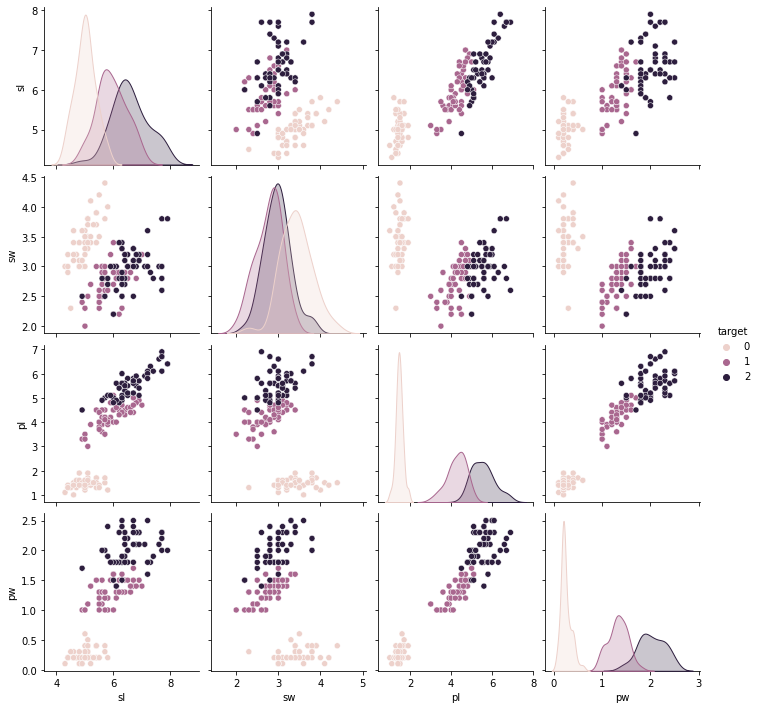

In [20]:
sns.pairplot(data=df,hue='target')


Our circuit consists of only one qubit. We encode the feature columns through a standardization, followed by a kernel PCA, followed by a min-max scaling into an angular interval. Note that we fit the Sklearn preprocessing instances before transforming the test data, to prevent data leakage.
We utilize ten variational parameters in our circuit and re-load the input data halfway through the circuit

In [28]:
w= ParameterVector('w',4)
t = ParameterVector('t',10)

qrq = QuantumRegister(1, 'q')
qc = QuantumCircuit(qrq)
qc.rz(w[0],qrq[0])
qc.ry(t[0],qrq[0])
qc.ry(w[1],qrq[0])
qc.rx(t[1],qrq[0])
qc.rx(w[2],qrq[0])
qc.rz(t[2],qrq[0])
qc.ry(w[3],qrq[0])
qc.ry(t[3],qrq[0])
qc.u(t[4], t[5], t[6], qrq[0])
qc.rx(w[0],qrq[0])
qc.rz(w[1],qrq[0])
qc.rx(w[2],qrq[0])
qc.ry(w[3],qrq[0])
qc.u(t[7], t[8], t[9], qrq[0])
qc = qc.decompose()

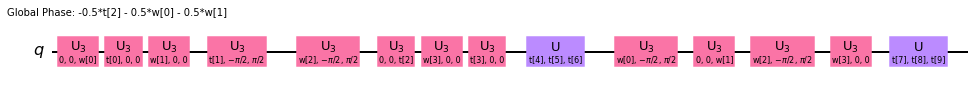

In [29]:
qc.decompose().draw()


We utilize the CircuitQNN class for classification. Our interpret function is effectively an identity function, though for pedantry we use a parity function. While the output space is two-dimensional, we achieve a multilabel classification scheme through comparing distribution functions with the L2 loss function.

In [30]:
output_shape=2
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=w,
    weight_params=t,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
    sampling=False
)

The output of the CircuitQNN is a distribution on the bits 0 and 1. We output as the classification of any two-element probability distribution the argmin of the L2 loss function against three "reference" distributions. These reference distributions can be chosen at will, though in our case we have chosen the three distributions (1/6,5/6), (1/2,1/2), and (5/6,1/6). These reference distributions split the space of two-element distributions into three equal pieces under the classification definition given above. Put differently, our classification scheme splits the Bloch sphere into two spherical caps and an equitorial band, though these three connected components do not necessarily have equal area.
To get an average accuracy, we perform a five-fold stratified cross-validation; the stratification is to ensure a equal balance of classes.

In [32]:
y = df.target.values

n_splits=5
skf = StratifiedKFold(n_splits=n_splits,shuffle=True)
skf.get_n_splits(df,df.target.values)
feature_cols = ['sl', 'sw', 'pl', 'pw']
new_cols = ['p1','p2','p3','p4']

prob_arr = np.array([[5/6,1/6],[1/6,5/6],[1/2,1/2]])

n_components = 4

results= []
for train_index, test_index in skf.split(df, df.target.values):
    X_train, y_train, X_test, y_test = df.loc[train_index], y[train_index], df.loc[test_index], y[test_index]
    #turning target labels into probability distributions
    y_train_p = turn_target_to_prob(y_train,prob_arr)
    #preprocessing the training and test data to prevent data leakage
    X_train, X_test = pre_process(X_train,X_test,n_components,feature_cols,new_cols)
    #using only the transformed angles for learning
    X_train = X_train[new_cols].to_numpy()
    X_test = X_test[new_cols].to_numpy()

    circuit_classifier = NeuralNetworkClassifier_Greg_Version(
    neural_network=circuit_qnn,
    optimizer=COBYLA(), 
    callback=callback_graph,
    loss='squared_error',
    one_hot=True,

    )
    circuit_classifier.fit(X_train, y_train_p)
    
    y_predict = circuit_classifier.predict(X_test)
    clas, y_p = extract_classification(y_test,y_predict,prob_arr)
    results.append(clas)


mean_acc, std_acc = np.mean(results),np.std(results)
print('accuracy for each run: ', results)
print('mean and standard deviation of accuracy',mean_acc, std_acc)

0.2891454043211761
0.35587046234696007
0.25245319825631607
0.13377844315988047
0.1159259248662878
0.28435831423159
0.11557643501846879
0.25662316569575555
0.1782132660901105
0.11673260618139199
0.10741043444033022
0.09896428143536602
0.05824377625076859
0.1847714883309824
0.07093091894079138
0.2542573169425682
0.06405208199112504
0.1249377656866003
0.10690384794164588
0.05530764085275156
0.12734404493261267
0.06925768145808468
0.08882482140152545
0.057908776954368316
0.07786799360204627
0.06183897477609141
0.09397776744983814
0.062329428284256555
0.05526985415705929
0.06399345751161929
0.07835224822715478
0.058118632987693514
0.05461406001338253
0.057438053908171485
0.05680869243763112
0.056232434731942636
0.05680542875219275
0.05420100777237504
0.056262650313200775
0.06156251518814653
0.05604348535890934
0.0531805921483923
0.052860019825122985
0.05312422999629269
0.053304723457053865
0.05392421969661007
0.053827310491491254
0.05338197107668277
0.053105596259788244
0.05422839941801849
